## Multi-label prediction with Banknotes

In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
import fastai
from fastai.vision import *

In [16]:
#For CPU only 
fastai.torch_core.defaults.device = 'cpu'
defaults.device= 'cpu'

## Multiclassification

In [20]:
path = Path('.') #'/home/jupyter/.fastai/data/banknotes/')
path_imgs=path/'imgs'
path_imgs.mkdir(parents=True, exist_ok=True)
path_imgs

PosixPath('imgs')

In [21]:
src = (ImageList.from_folder(path_imgs,recurse=True)
               .split_by_rand_pct(valid_pct=.2))

src

ItemLists;

Train: ImageList (679 items)
Image (3, 201, 500),Image (3, 212, 500),Image (3, 225, 500),Image (3, 219, 500),Image (3, 281, 500)
Path: imgs;

Valid: ImageList (169 items)
Image (3, 640, 480),Image (3, 480, 640),Image (3, 238, 470),Image (3, 500, 421),Image (3, 375, 500)
Path: imgs;

Test: None

In [22]:
src.train.items[0]

PosixPath('imgs/usd/50/IMG_20190730_232610.jpg')

In [7]:
#single class
func=lambda i: str(i.parent.relative_to(path_imgs) )
#multi class
func=lambda i: (i.parent.relative_to(path_imgs).parts )
func(src.train.items[0])

('euro', '5')

In [8]:
ll = src.label_from_func(func); ll
#ll = src.label_from_folder(); ll

LabelLists;

Train: LabelList (211 items)
x: ImageList
Image (3, 428, 500),Image (3, 255, 500),Image (3, 255, 500),Image (3, 500, 305),Image (3, 500, 435)
y: MultiCategoryList
euro;5,euro;5,euro;5,euro;5,euro;5
Path: /home/jupyter/.fastai/data/banknotes/imgs;

Valid: LabelList (52 items)
x: ImageList
Image (3, 278, 500),Image (3, 267, 500),Image (3, 217, 500),Image (3, 400, 500),Image (3, 333, 500)
y: MultiCategoryList
euro;200,euro;200,usd;100,usd;5,usd;10
Path: /home/jupyter/.fastai/data/banknotes/imgs;

Test: None

In [9]:
tfms = get_transforms(do_flip=True,flip_vert=True, 
                      max_rotate=90, 
                      max_zoom=1.5, 
                      max_lighting=0.5, 
                      max_warp=0.5)

In [10]:
#so its reproducible
#np.random.seed(42)

In [11]:
def get_data(size,bs):
    size=int(size)
    bs=int(bs)
    data = (ll.transform(tfms, size=size)
        .databunch(bs=bs) #for CPU only add ,num_workers=0
        .normalize(imagenet_stats))
    return data
size,bs=256/2,20
data=get_data(size,bs)

In [12]:
data.classes

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']

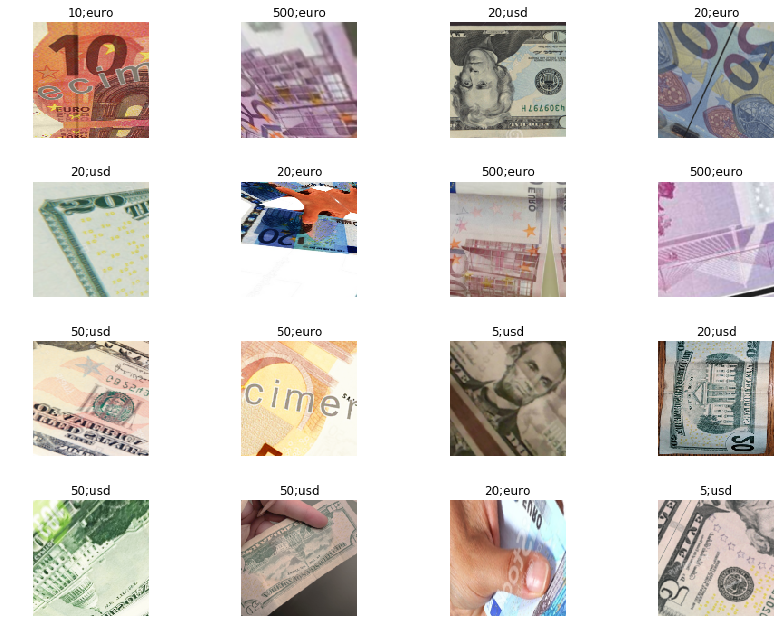

In [13]:
data.show_batch(rows=4, figsize=(12,9))

In [14]:
arch = models.resnet50

In [15]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
#multiclass
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])
#single class
#learn = cnn_learner(data, arch, metrics=[accuracy])

We use the LR Finder to pick a good learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


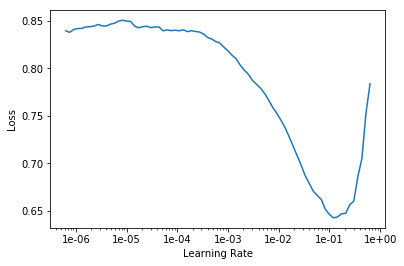

In [16]:
learn.lr_find()
learn.recorder.plot()

Then we can fit the head of our network.

In [17]:
lr = 1e-2

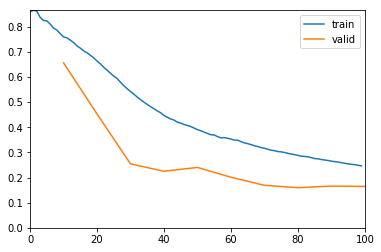

In [18]:
learn.fit_one_cycle(10, slice(lr),callbacks=ShowGraph(learn))

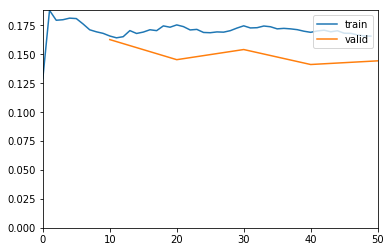

In [19]:
learn.fit_one_cycle(5, slice(lr),callbacks=ShowGraph(learn))

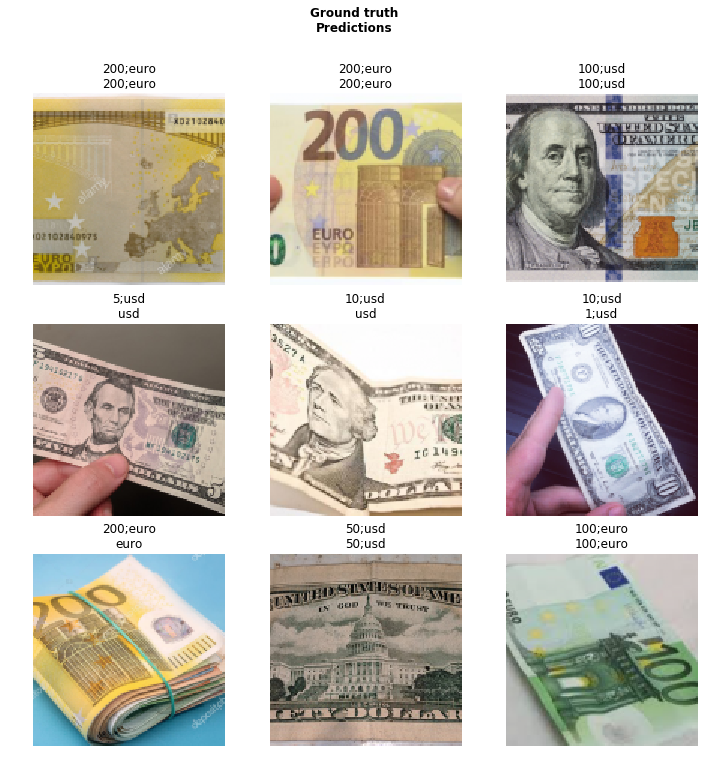

In [20]:
learn.show_results(rows=3)

In [21]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


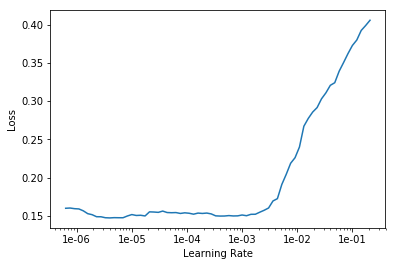

In [23]:
learn.lr_find()
learn.recorder.plot()

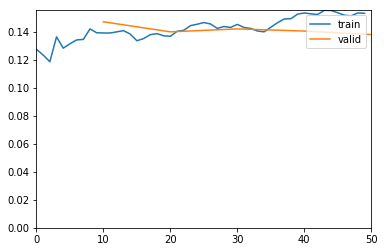

In [24]:
lr=1e-4
learn.fit_one_cycle(5, slice(1e-5, lr/5),callbacks=ShowGraph(learn))

In [51]:
learn.save('stage-2-rn50')

In [45]:
learn.load('stage-2-rn50');

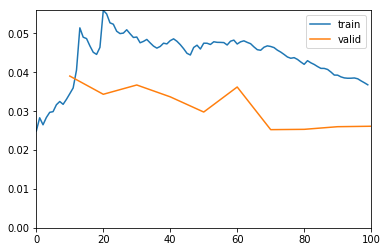

In [55]:
learn.fit_one_cycle(10, slice(1e-5, lr/5),callbacks=ShowGraph(learn))

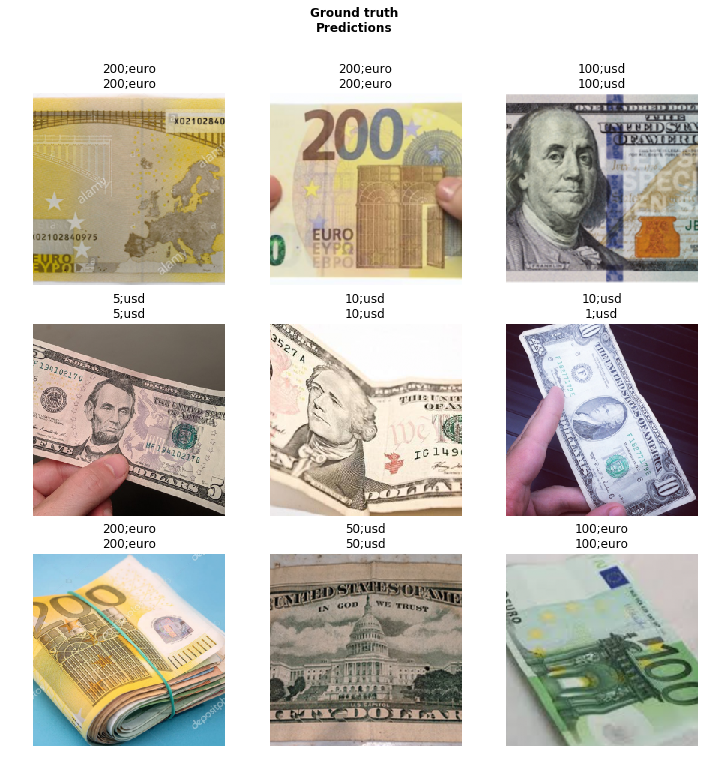

In [57]:
learn.show_results(rows=3)

In [62]:
learn.save('stage-3-rn50')

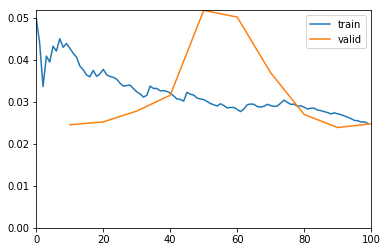

In [59]:
learn.fit_one_cycle(10, slice(1e-5, lr/5),callbacks=ShowGraph(learn))

In [60]:
gc.collect()
torch.cuda.empty_cache()

In [61]:
size,bs=256,10/4
data=get_data(size,bs)

In [63]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


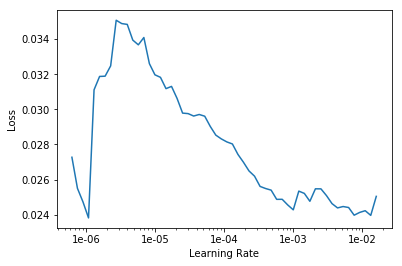

In [64]:
learn.lr_find()
learn.recorder.plot()


In [65]:
lr=1e-4

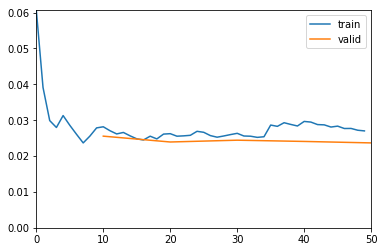

In [66]:
learn.fit_one_cycle(5, slice(lr),callbacks=ShowGraph(learn))

In [69]:
learn.save('stage-1-256-rn50')

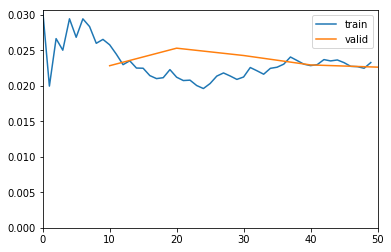

In [70]:
learn.fit_one_cycle(5, slice(lr),callbacks=ShowGraph(learn))

In [71]:
learn.save('stage-1-256-rn50')

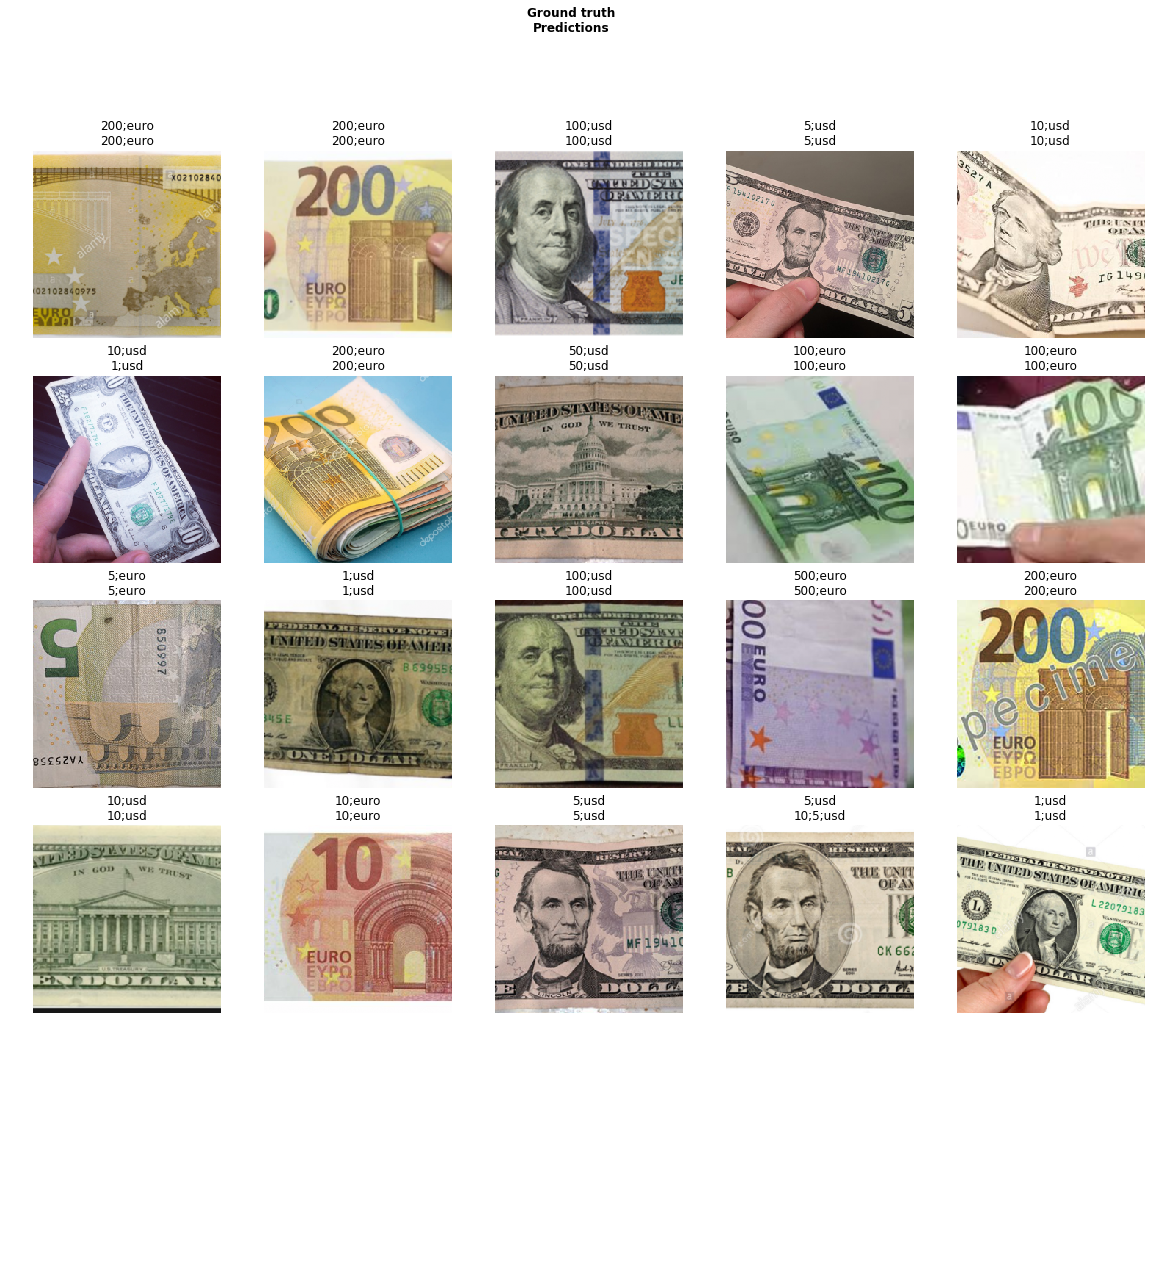

In [72]:
learn.show_results()

In [73]:
learn.unfreeze()

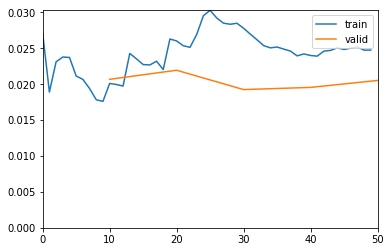

In [75]:
learn.fit_one_cycle(5, slice(1e-5, lr/5),callbacks=ShowGraph(learn))

In [94]:
learn.save('stage-2-256-rn50-fbeta9930')

In [92]:
learn.load('stage-2-256-rn50');

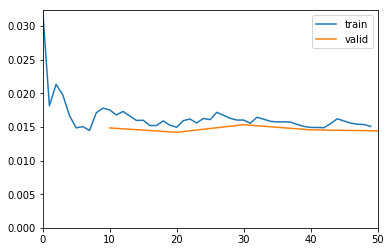

In [95]:
learn.fit_one_cycle(5, slice(1e-5, lr/5),callbacks=ShowGraph(learn))

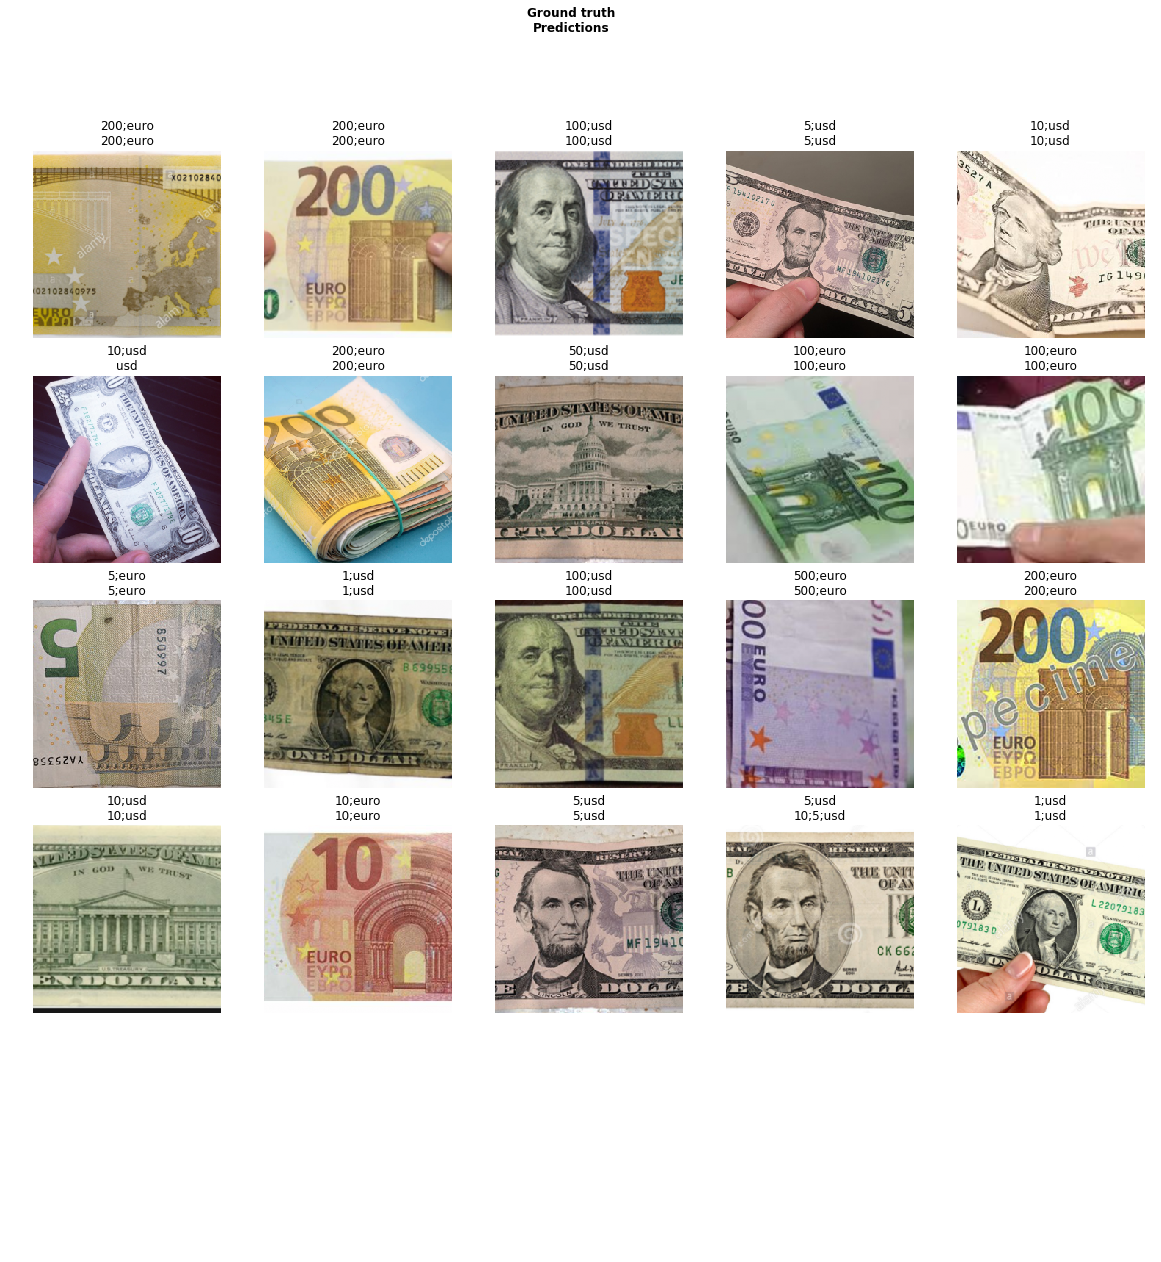

In [96]:
learn.show_results()

In [97]:
learn.save('multi-class')

# Inference example

In [57]:
imgPath=src.train.items[0]
img = open_image(imgPath)
pred=learn.predict(img)
probabilities=[ '%.2f' % float(100*elem) for elem in pred[2] ]
dict(zip(classes,probabilities))

{'1': '0.26',
 '10': '0.03',
 '100': '0.00',
 '20': '0.01',
 '200': '0.00',
 '5': '0.03',
 '50': '99.99',
 '500': '0.00',
 'euro': '0.00',
 'usd': '100.00'}

In [64]:
a=[b'1', b'10', b'100', b'20', b'200', b'5', b'50', b'500', b'euro', b'usd']
[c.decode("utf-8") for c in a]

['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']

In [98]:
learn.export(file='multi-class.pkl')

# Convert to PyTorch model in TorchScript format 

In [7]:
path_img = Path('models/')
model_file = 'multi-class.pkl'
learn = load_learner( path_img , model_file )

In [10]:
model_file_jit = 'multi-class_jit.pth'
classes_file='classes.txt'
classes = ['1', '10', '100', '20', '200', '5', '50', '500', 'euro', 'usd']

#trace_input = torch.ones(1,3,299,299).cuda()
trace_input = torch.ones(1,3,299,299)
jit_model = torch.jit.trace(learn.model.float(), trace_input)
output_path = str(path_img/f'{model_file_jit}')
torch.jit.save(jit_model, output_path)
# export classes text file
save_texts(path_img/'classes.txt', classes)
tar_file=path_img/'model.tar.gz'

# create a tarfile with the exported model and classes text file
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path_img/f'{model_file_jit}', arcname=model_file_jit)
    f.add(path_img/f'{classes_file}', arcname=classes_file)

## Upload to the S3 bucket

In [11]:
import boto3
s3 = boto3.resource('s3')
bucket = 'iris-ai'
s3.meta.client.upload_file(tar_file.as_posix(), bucket, 'fastai-models/iris/model.tar.gz')
